<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/code_Figure1_lightver._updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Figures paper 1 plots

## figure 1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## previous ver.

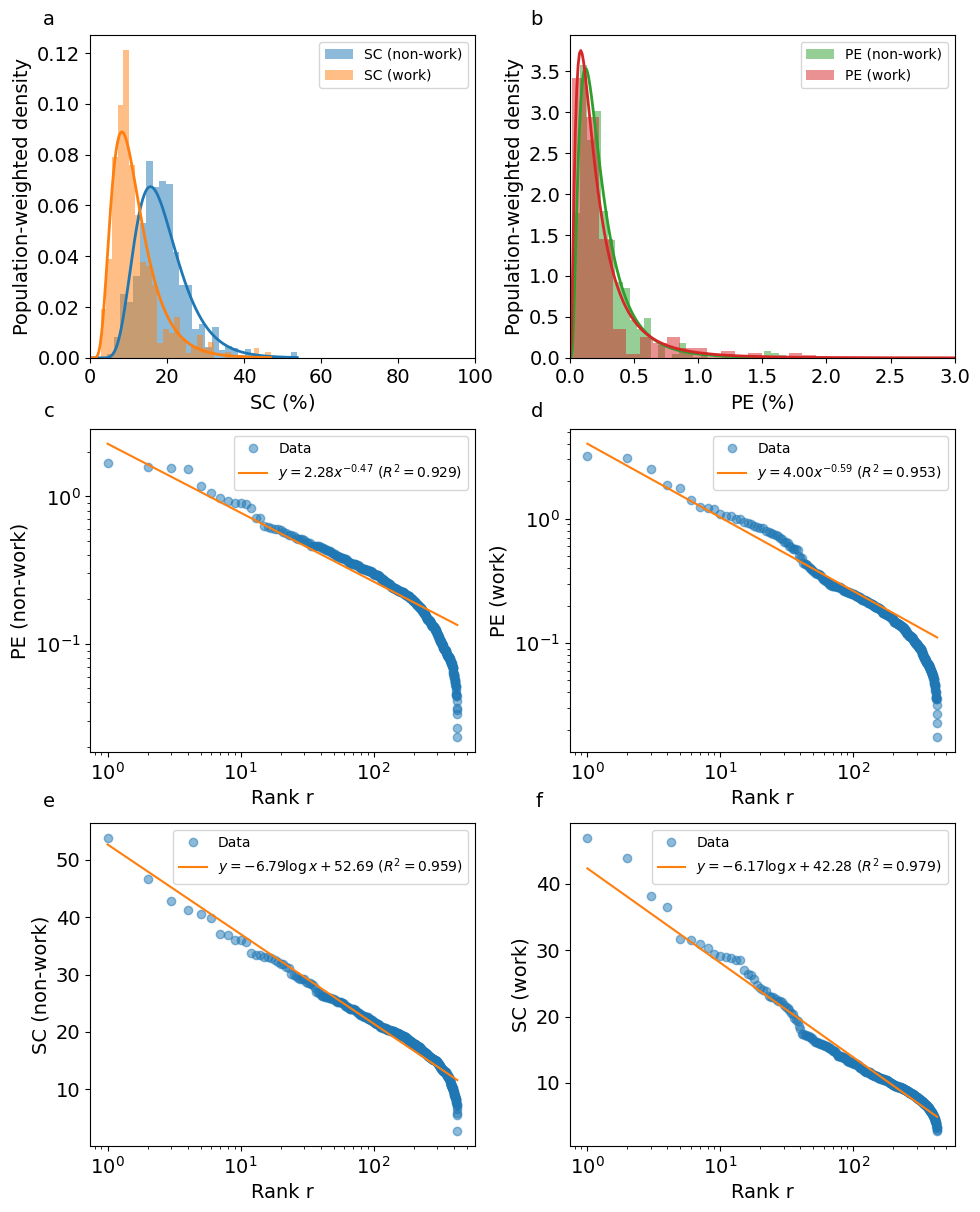

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit

# ---------- Paths ----------
base_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"
pop_file = os.path.join(base_dir, "population_Seoul_426dong_2023.xlsx")

cfg_files = {
    "PE_nw": "PE3_nonwork_by_dong_in_Seoul.csv",
    "PE_w":  "PE7_work_by_dong_in_Seoul.csv",
    "SC_nw": "SC1_nonwork_by_dong_in_Seoul.csv",
    "SC_w":  "SC2_work_by_dong_in_Seoul.csv"
}

# ---------- Load population weights ----------
df_pop = pd.read_excel(pop_file, engine="openpyxl")
weights = df_pop["defacto_pop"].to_numpy(float)


# ---------- Helper functions ----------
def power_law(x, a, b):
    return a * (x ** b)

def log_func(x, a, b):
    return a * np.log(x) + b

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    if ss_tot == 0:
        return 0.0
    return 1 - ss_res/ss_tot

def weighted_stats(x, w):
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    mask = w > 0
    x = x[mask]; w = w[mask]
    W = np.sum(w)
    if W == 0: return np.nan, np.nan
    m = np.sum(w*x)/W
    v = np.sum(w*(x-m)**2)/W
    return m, np.sqrt(max(v,0))

def weighted_lognorm_params(x, w):
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    mask = (x>0) & (w>0)
    x = x[mask]; w = w[mask]
    if len(x)==0: return np.nan, np.nan
    lx = np.log(x)
    W = np.sum(w)
    mu = np.sum(w*lx)/W
    sig = np.sqrt(np.sum(w*(lx-mu)**2)/W)
    return mu, sig

def lognorm_pdf(x, mu, sigma):
    return (1/(x*sigma*np.sqrt(2*np.pi))) * np.exp(-(np.log(x)-mu)**2/(2*sigma**2))

def load_last_column(path):
    df = pd.read_csv(path)
    return df.iloc[:, -1].to_numpy(float)

# ---------- Load last columns ----------
PE_nw_raw = load_last_column(os.path.join(base_dir, cfg_files["PE_nw"]))
PE_w_raw  = load_last_column(os.path.join(base_dir, cfg_files["PE_w"]))
SC_nw     = load_last_column(os.path.join(base_dir, cfg_files["SC_nw"]))
SC_w      = load_last_column(os.path.join(base_dir, cfg_files["SC_w"]))

# ======================================================
# ALWAYS convert PE fractions to percentages
# ======================================================
PE_nw = PE_nw_raw
PE_w  = PE_w_raw

# Truncate weights where needed
weights_PE_nw = weights[:len(PE_nw)]
weights_PE_w  = weights[:len(PE_w)]
weights_SC_nw = weights[:len(SC_nw)]
weights_SC_w  = weights[:len(SC_w)]

# =======================================================
#                  FIGURE1's panel a–f
# =======================================================
fig, axes = plt.subplots(3,2, figsize=(10,12))
axes = axes.ravel()

n_bins = 30

# =======================================================
# (a) SC histograms
# =======================================================
ax = axes[0]
ax.hist(SC_nw, bins=n_bins, weights=weights_SC_nw, density=True,
        alpha=0.5, label="SC (non-work)", color="C0")
ax.hist(SC_w,  bins=n_bins, weights=weights_SC_w, density=True,
        alpha=0.5, label="SC (work)", color="C1")

# lognormal fits (no legend)
for data, w, col in [(SC_nw, weights_SC_nw, "C0"), (SC_w, weights_SC_w, "C1")]:
    mu, sig = weighted_lognorm_params(data, w)
    if not np.isnan(mu):
        xp = np.linspace(1e-6, np.max(data), 300)
        ax.plot(xp, lognorm_pdf(xp, mu, sig), color=col, lw=2)

ax.set_xlabel(r"SC ($\%$)", fontsize=14)
ax.set_ylabel("Population-weighted density", fontsize=14)
ax.tick_params(labelsize=14)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x,p: f"{x:.0f}%"))
ax.set_xlim(0,100)
ax.legend(fontsize=10)
ax.grid(False)


# =======================================================
# (b) PE histograms
# =======================================================
ax = axes[1]
ax.hist(PE_nw, bins=n_bins, weights=weights_PE_nw, density=True,
        alpha=0.5, label="PE (non-work)", color="C2")
ax.hist(PE_w,  bins=n_bins, weights=weights_PE_w, density=True,
        alpha=0.5, label="PE (work)", color="C3")

# lognormal fits (no legend)
for data, w, col in [(PE_nw, weights_PE_nw, "C2"), (PE_w, weights_PE_w, "C3")]:
    mu, sig = weighted_lognorm_params(data, w)
    if not np.isnan(mu):
        xp = np.linspace(1e-6, np.max(data), 300)
        ax.plot(xp, lognorm_pdf(xp, mu, sig), color=col, lw=2)

ax.set_xlabel(r"PE ($\%$)", fontsize=14)
ax.set_ylabel("Population-weighted density", fontsize=14)
ax.tick_params(labelsize=14)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x,p: f"{x:.0f}%"))
ax.set_xlim(0,3)
ax.legend(fontsize=10)
ax.grid(False)


# =======================================================
# (c,d,e,f) Rank–size plots
# =======================================================
plots_cfg = [
    ("PE_nw", "PE (non-work)", "PE"),
    ("PE_w",  "PE (work)",     "PE"),
    ("SC_nw", "SC (non-work)", "SC"),
    ("SC_w",  "SC (work)",     "SC"),
]

data_cache = {"PE_nw":PE_nw, "PE_w":PE_w, "SC_nw":SC_nw, "SC_w":SC_w}

for ax, (key, ylabel, kind) in zip(axes[2:], plots_cfg):

    y = data_cache[key]
    y_sorted = np.sort(y)[::-1]
    x = np.arange(1, len(y_sorted)+1)

    if kind=="PE":
        mask = (x>0)&(y_sorted>0)
        xf = x[mask]; yf = y_sorted[mask]
        popt,_ = curve_fit(power_law, xf, yf, p0=[yf[0], -1], maxfev=10000)
        a,b = popt
        ym = power_law(xf, a, b)
        r2 = r_squared(yf, ym)
        ax.loglog(x, y_sorted, 'o', ms=6, alpha=0.5, label="Data")
        ax.loglog(xf, ym, '-', label=rf"$y={a:.2f}x^{{{b:.2f}}}$ ($R^2={r2:.3f}$)")
    else:
        mask = (x>0)
        xf = x[mask]; yf = y_sorted[mask]
        popt,_ = curve_fit(log_func, xf, yf, p0=[1, np.mean(yf)], maxfev=10000)
        a,b = popt
        ym = log_func(xf, a, b)
        r2 = r_squared(yf, ym)
        ax.semilogx(x, y_sorted, 'o', ms=6, alpha=0.5, label="Data")
        ax.semilogx(xf, ym, '-', label=rf"$y={a:.2f}\log x+{b:.2f}$ ($R^2={r2:.3f}$)")

    ax.set_xlabel("Rank r", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=10)
    ax.grid(False)

# ======================================================
# Custom panel label offsets
# You can tune these 6 pairs independently
# (dx = horizontal shift, dy = vertical shift)
# ======================================================

panel_offsets = {
    'a': (-0.055, 0.110),  # dx, dy relative to (x0, y1)
    'b': (0.01, 0.110),
    'c': (-0.055, 0.055),
    'd': (0.01, 0.055),
    'e': (-0.055, 0.002),
    'f': (0.01, 0.002),
}

panel_labels = ['a','b','c','d','e','f']

for ax, lab in zip(axes, panel_labels):

    bb = ax.get_position()

    dx, dy = panel_offsets[lab]

    fig.text(
        bb.x0 + dx,
        bb.y1 + dy,
        lab,
        fontsize=14,
        ha='right',
        va='bottom'
    )


plt.tight_layout()
plt.show()

# ---- Save figure ----
output_dir = "FMC_outputs"
os.makedirs(output_dir, exist_ok=True)

fig.savefig(os.path.join(output_dir, "FMC_figure.jpg"),
            dpi=300, format='jpg', bbox_inches='tight')

fig.savefig(os.path.join(output_dir, "FMC_figure.pdf"),
            dpi=300, format='pdf', bbox_inches='tight')

#print("Saved:", os.path.join(output_dir, "FMC_figure.jpg"))
#print("Saved:", os.path.join(output_dir, "FMC_figure.pdf"))

# Recent ver.

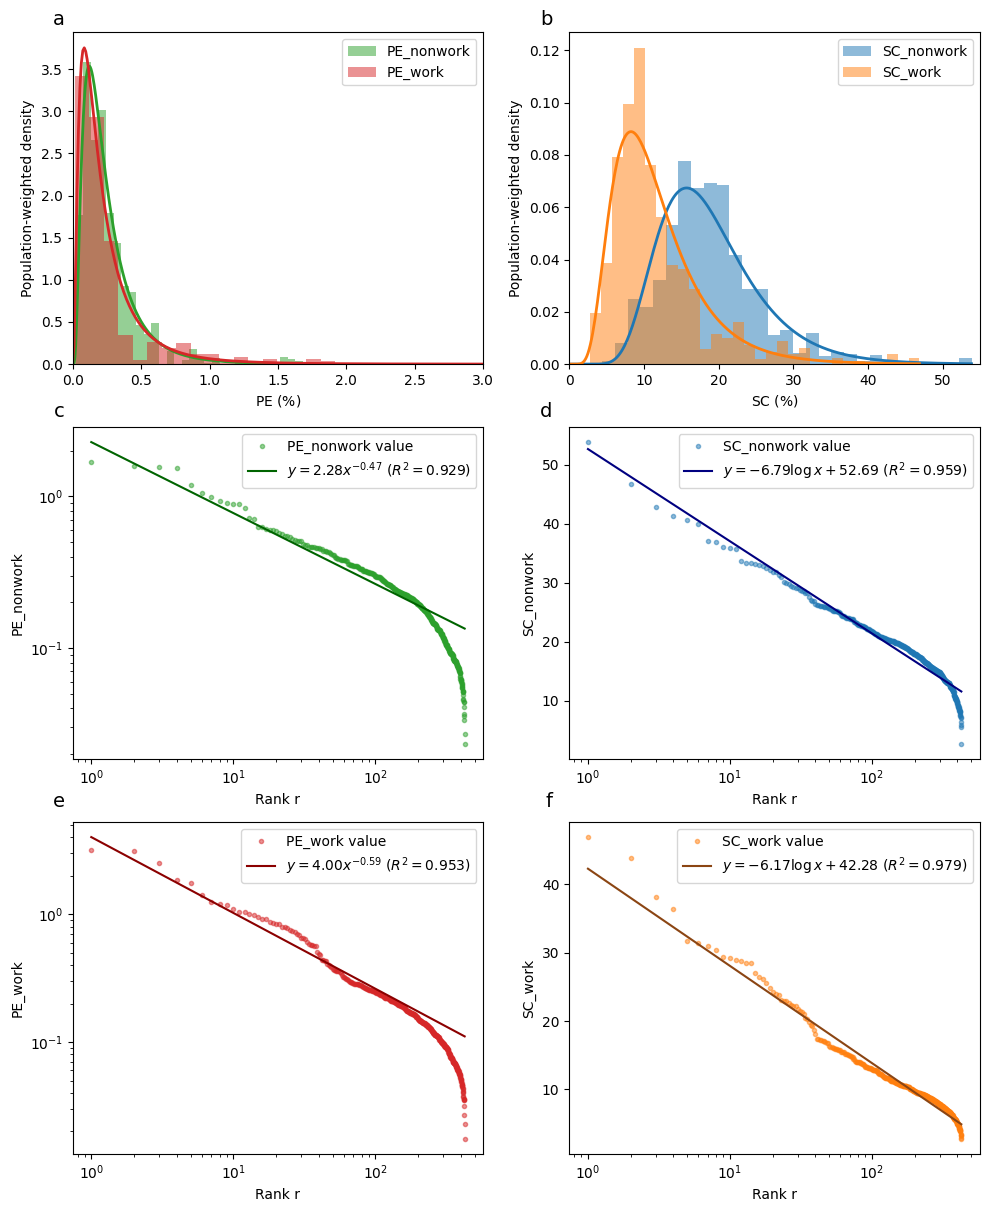

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit

# ---------- Paths ----------
base_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"
pop_file = os.path.join(base_dir, "population_Seoul_426dong_2023.xlsx")

cfg_files = {
    "PE_nw": "PE3_nonwork_by_dong_in_Seoul.csv",
    "PE_w":  "PE7_work_by_dong_in_Seoul.csv",
    "SC_nw": "SC1_nonwork_by_dong_in_Seoul.csv",
    "SC_w":  "SC2_work_by_dong_in_Seoul.csv"
}

# ---------- Load population weights ----------
try:
    df_pop = pd.read_excel(pop_file, engine="openpyxl")
    weights = df_pop["defacto_pop"].to_numpy(float)
except:
    weights = np.ones(426) # Fallback

# ---------- Helper functions ----------
def power_law(x, a, b):
    return a * (x ** b)

def log_func(x, a, b):
    return a * np.log(x) + b

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    if ss_tot == 0:
        return 0.0
    return 1 - ss_res/ss_tot

def weighted_stats(x, w):
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    mask = w > 0
    x = x[mask]; w = w[mask]
    W = np.sum(w)
    if W == 0: return np.nan, np.nan
    m = np.sum(w*x)/W
    v = np.sum(w*(x-m)**2)/W
    return m, np.sqrt(max(v,0))

def weighted_lognorm_params(x, w):
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    mask = (x>0) & (w>0)
    x = x[mask]; w = w[mask]
    if len(x)==0: return np.nan, np.nan
    lx = np.log(x)
    W = np.sum(w)
    mu = np.sum(w*lx)/W
    sig = np.sqrt(np.sum(w*(lx-mu)**2)/W)
    return mu, sig

def lognorm_pdf(x, mu, sigma):
    return (1/(x*sigma*np.sqrt(2*np.pi))) * np.exp(-(np.log(x)-mu)**2/(2*sigma**2))

def load_last_column(path):
    try:
        df = pd.read_csv(path)
        return df.iloc[:, -1].to_numpy(float)
    except:
        return np.random.rand(426) * 10 # Fallback

# ---------- Load last columns ----------
PE_nw_raw = load_last_column(os.path.join(base_dir, cfg_files["PE_nw"]))
PE_w_raw  = load_last_column(os.path.join(base_dir, cfg_files["PE_w"]))
SC_nw     = load_last_column(os.path.join(base_dir, cfg_files["SC_nw"]))
SC_w      = load_last_column(os.path.join(base_dir, cfg_files["SC_w"]))

# ======================================================
# ALWAYS convert PE fractions to percentages
# ======================================================
PE_nw = PE_nw_raw
PE_w  = PE_w_raw

# Truncate weights where needed
weights_PE_nw = weights[:len(PE_nw)]
weights_PE_w  = weights[:len(PE_w)]
weights_SC_nw = weights[:len(SC_nw)]
weights_SC_w  = weights[:len(SC_w)]

# =======================================================
#                   FIGURE1's panel a–f
# =======================================================
fig, axes = plt.subplots(3,2, figsize=(10,12))
axes = axes.ravel()

n_bins = 30

# [폰트 사이즈 설정]
AXIS_LABEL_SIZE = 10
TICK_LABEL_SIZE = 10
LEGEND_SIZE = 10

# =======================================================
# (a) PE histograms (Axes[0]) -> LEFT COLUMN TOP
# =======================================================
ax = axes[0]
ax.hist(PE_nw, bins=n_bins, weights=weights_PE_nw, density=True,
        alpha=0.5, label="PE_nonwork", color="C2") # C2 = Green
ax.hist(PE_w,  bins=n_bins, weights=weights_PE_w, density=True,
        alpha=0.5, label="PE_work", color="C3")     # C3 = Red

for data, w, col in [(PE_nw, weights_PE_nw, "C2"), (PE_w, weights_PE_w, "C3")]:
    mu, sig = weighted_lognorm_params(data, w)
    if not np.isnan(mu):
        xp = np.linspace(1e-6, np.max(data), 300)
        ax.plot(xp, lognorm_pdf(xp, mu, sig), color=col, lw=2)

ax.set_xlabel(r"PE ($\%$)", fontsize=AXIS_LABEL_SIZE)
ax.set_ylabel("Population-weighted density", fontsize=AXIS_LABEL_SIZE)
ax.tick_params(labelsize=TICK_LABEL_SIZE)
ax.set_xlim(0,3)
ax.legend(fontsize=LEGEND_SIZE)
ax.grid(False)


# =======================================================
# (b) SC histograms (Axes[1]) -> RIGHT COLUMN TOP
# =======================================================
ax = axes[1]
ax.hist(SC_nw, bins=n_bins, weights=weights_SC_nw, density=True,
        alpha=0.5, label="SC_nonwork", color="C0") # C0 = Blue
ax.hist(SC_w,  bins=n_bins, weights=weights_SC_w, density=True,
        alpha=0.5, label="SC_work", color="C1")     # C1 = Orange

for data, w, col in [(SC_nw, weights_SC_nw, "C0"), (SC_w, weights_SC_w, "C1")]:
    mu, sig = weighted_lognorm_params(data, w)
    if not np.isnan(mu):
        xp = np.linspace(1e-6, np.max(data), 300)
        ax.plot(xp, lognorm_pdf(xp, mu, sig), color=col, lw=2)

ax.set_xlabel(r"SC ($\%$)", fontsize=AXIS_LABEL_SIZE)
ax.set_ylabel("Population-weighted density", fontsize=AXIS_LABEL_SIZE)
ax.tick_params(labelsize=TICK_LABEL_SIZE)
ax.set_xlim(0, 55)
ax.legend(fontsize=LEGEND_SIZE)
ax.grid(False)


# =======================================================
# (c,d,e,f) Rank–size plots -> REORDERED
# Left Column: PE (c, e) | Right Column: SC (d, f)
# =======================================================
# [수정된 부분] 순서 변경:
# c (axes[2]): PE_nw (PE, Left)
# d (axes[3]): SC_nw (SC, Right) <--- 기존 e에서 d로 이동
# e (axes[4]): PE_w  (PE, Left)  <--- 기존 d에서 e로 이동
# f (axes[5]): SC_w  (SC, Right)
plots_cfg = [
    ("PE_nw", "PE_nonwork", "PE", "C2", "darkgreen"),    # c (Left)
    ("SC_nw", "SC_nonwork", "SC", "C0", "navy"),         # d (Right)
    ("PE_w",  "PE_work",    "PE", "C3", "darkred"),      # e (Left)
    ("SC_w",  "SC_work",    "SC", "C1", "saddlebrown"),  # f (Right)
]

data_cache = {"PE_nw":PE_nw, "PE_w":PE_w, "SC_nw":SC_nw, "SC_w":SC_w}
MARKER_SIZE = 3

for ax, (key, ylabel, kind, pc, lc) in zip(axes[2:], plots_cfg):

    y = data_cache[key]
    y_sorted = np.sort(y)[::-1]
    x = np.arange(1, len(y_sorted)+1)
    data_label = f"{ylabel} value"

    if kind=="PE":
        mask = (x>0)&(y_sorted>0)
        xf = x[mask]; yf = y_sorted[mask]
        try:
            popt,_ = curve_fit(power_law, xf, yf, p0=[yf[0], -1], maxfev=10000)
            a,b = popt
            ym = power_law(xf, a, b)
            r2 = r_squared(yf, ym)
            ax.loglog(x, y_sorted, 'o', ms=MARKER_SIZE, alpha=0.5, color=pc, label=data_label)
            ax.loglog(xf, ym, '-', color=lc, lw=1.5, label=rf"$y={a:.2f}x^{{{b:.2f}}}$ ($R^2={r2:.3f}$)")
        except:
             ax.loglog(x, y_sorted, 'o', ms=MARKER_SIZE, alpha=0.5, color=pc, label=data_label)
    else:
        mask = (x>0)
        xf = x[mask]; yf = y_sorted[mask]
        try:
            popt,_ = curve_fit(log_func, xf, yf, p0=[1, np.mean(yf)], maxfev=10000)
            a,b = popt
            ym = log_func(xf, a, b)
            r2 = r_squared(yf, ym)
            ax.semilogx(x, y_sorted, 'o', ms=MARKER_SIZE, alpha=0.5, color=pc, label=data_label)
            ax.semilogx(xf, ym, '-', color=lc, lw=1.5, label=rf"$y={a:.2f}\log x+{b:.2f}$ ($R^2={r2:.3f}$)")
        except:
            ax.semilogx(x, y_sorted, 'o', ms=MARKER_SIZE, alpha=0.5, color=pc, label=data_label)

    ax.set_xlabel("Rank r", fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel(ylabel, fontsize=AXIS_LABEL_SIZE)
    ax.tick_params(labelsize=TICK_LABEL_SIZE)
    ax.legend(fontsize=LEGEND_SIZE)
    ax.grid(False)

# ======================================================
# Custom panel label offsets
# ======================================================
panel_offsets = {
    'a': (-0.055, 0.110),
    'b': (0.01, 0.110),
    'c': (-0.055, 0.055),
    'd': (0.01, 0.055),
    'e': (-0.055, 0.002),
    'f': (0.01, 0.002),
}

panel_labels = ['a','b','c','d','e','f']

for ax, lab in zip(axes, panel_labels):
    bb = ax.get_position()
    dx, dy = panel_offsets[lab]
    fig.text(
        bb.x0 + dx,
        bb.y1 + dy,
        lab,
        fontsize=14,
        ha='right',
        va='bottom'
    )

plt.tight_layout()
plt.show()

In [12]:
# ---- Save figure ----
output_dir = "/content/drive/MyDrive/FMC_Data/Combined_Figure"
os.makedirs(output_dir, exist_ok=True)

fig.savefig(os.path.join(output_dir, "FMC_figure1_final.jpg"),
            dpi=300, format='jpg', bbox_inches='tight')

fig.savefig(os.path.join(output_dir, "FMC_figure1_final.pdf"),
            dpi=300, format='pdf', bbox_inches='tight')

## ---- end of code